# Setup

In [1]:
import sys
sys.path.insert(
    0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

In [2]:
import sys
sys.path.insert(0, '/home/563/esh563/TINT')

In [3]:
# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import caine_func as caf
import analysis

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF
%aimport tint.process_ACCESS

%pdb


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.int, "int"), (np.int8, "int"),
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/gexf.py:220: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to us

Automatic pdb calling has been turned ON


In [4]:
base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

In [5]:
base_dir = '/g/data/hj10/cpol/cpol_level_1b/v2020/gridded/grid_150km_2500m/'
save_dir = '/home/563/esh563/TINT_tracks/'
fig_dir = '/home/563/esh563/TINT_figures/'
ERA5_dir = '/g/data/rt52/era5/pressure-levels/reanalysis/'

# Create Tracks

In [6]:
b_path = '/home/student.unimelb.edu.au/shorte1/Documents/'
b_path += 'CPOL_analysis/circ_b_ind_set.pkl'
with open(b_path, 'rb') as f:
    b_ind_set = pickle.load(f)

In [7]:
topog_files = open('topog_files.txt', 'r')
topog_files = topog_files.read().split('\n')[:-1]
u_files = open('u_files.txt', 'r')
u_files = u_files.read().split('\n')[:-1]
v_files = open('v_files.txt', 'r')
v_files = v_files.read().split('\n')[:-1]
maxcol_refl_files = open('maxcol_refl_files.txt', 'r')
maxcol_refl_files = maxcol_refl_files.read().split('\n')[:-1]
radar_refl_1km_files = open('radar_refl_1km_files.txt', 'r')
radar_refl_1km_files = radar_refl_1km_files.read().split('\n')[:-1]

files_list = [
    topog_files, u_files, v_files, maxcol_refl_files, radar_refl_1km_files]

dates_list = []
for files in files_list:

    dates = [f.split('/')[7] for f in files]
    dates = [
        np.datetime64('{}-{}-{}'.format(f[:4], f[4:6], f[6:8])) 
        for f in dates]
    dates_list.append(set(dates))
    
[topog_dates, u_dates, v_dates, maxcol_refl_dates, radar_refl_1km_dates] = dates_list

In [8]:
files_63 = open('files_63.txt', 'r')
files_63 = files_63.read().split('\n')[:-1]
files_77 = open('files_77.txt', 'r')
files_77 = files_77.read().split('\n')[:-1]
files_42 = open('files_42.txt', 'r')
files_42 = files_42.read().split('\n')[:-1]

files_list = [
    files_63, files_77, files_42]

dates_list = []
for files in files_list:

    dates = [f.split('/')[9].split('_')[1] for f in files]
    dates = [
        np.datetime64('{}-{}-{}'.format(f[:4], f[4:6], f[6:8])) 
        for f in dates]
    dates_list.append(set(dates))
    
[dates_63, dates_77, dates_42] = dates_list

In [9]:
start = np.datetime64('2020-10-01T00:00:00')
end = np.datetime64('2021-05-01T00:00:00')
datetimes_a = np.arange(start, end, np.timedelta64(10,'m'))

In [5]:
start = np.datetime64('2021-10-01T00:00:00')
end = np.datetime64('2022-05-01T00:00:00')
datetimes_b = np.arange(start, end, np.timedelta64(10,'m'))

In [11]:
datetimes = np.concatenate([datetimes_a, datetimes_b])

In [20]:
start = np.datetime64('2020-12-01T00:00:00')
end = np.datetime64('2020-12-02T00:00:00')
datetimes = np.arange(start, end, np.timedelta64(10,'m'))

In [15]:
common_dates = []
membership = []

dates_int = maxcol_refl_dates.intersection(
    radar_refl_1km_dates, dates_63, dates_42, dates_77)

G3_int = u_dates.intersection(v_dates)

for dt in datetimes:
    # Remember we use the previous day's reflectivity at 1200 
    date = np.datetime64(str(dt)[0:10])
    current_date = np.datetime64(str(dt)[0:10])
    hour = int(str(dt)[11:13])
    hour_round = (hour // 6) * 6
    date_hour = current_date + np.timedelta64(hour_round, 'h')
#     import pdb; pdb.set_trace()
    date_cond = date in dates_int
    hour_cond = (
        (date_hour in G3_int)
        and (date_hour + np.timedelta64(6, 'h') in G3_int))
    if date_cond:
        common_dates.append(dt)
        membership.append(1)
    else:
        membership.append(0)

In [22]:
np.datetime64('2021-03-31T00:00') in common_dates

True

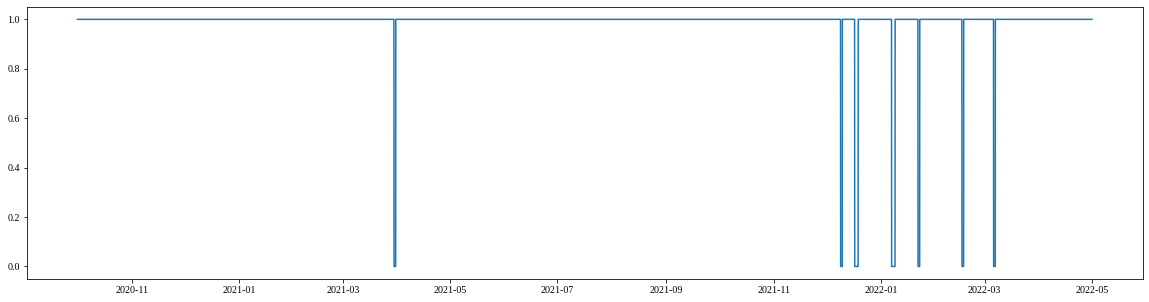

In [19]:
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'mathtext.fontset': 'dejavuserif'})
rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(datetimes, membership)

In [8]:
start = np.datetime64('2021-10-01T00:00:00')
end = np.datetime64('2022-05-01T00:00:00')
datetimes = np.arange(start, end, np.timedelta64(10,'m'))
datetimes = sorted([d for d in datetimes if d in common_times])
datetimes[-10:]

[numpy.datetime64('2022-04-30T22:20:00'),
 numpy.datetime64('2022-04-30T22:30:00'),
 numpy.datetime64('2022-04-30T22:40:00'),
 numpy.datetime64('2022-04-30T22:50:00'),
 numpy.datetime64('2022-04-30T23:00:00'),
 numpy.datetime64('2022-04-30T23:10:00'),
 numpy.datetime64('2022-04-30T23:20:00'),
 numpy.datetime64('2022-04-30T23:30:00'),
 numpy.datetime64('2022-04-30T23:40:00'),
 numpy.datetime64('2022-04-30T23:50:00')]

In [20]:
date_strings = list(np.array(common_dates).astype(str))
np.savetxt(
    'radar_common_times.csv', date_strings, delimiter =", ", fmt ='% s')

In [6]:
# Note different from above due to day lag 
common_times = np.loadtxt(
    'ACCESS_radar_common_times.csv', dtype=str).astype(np.datetime64)

In [6]:
datetimes = np.arange(
    np.datetime64('2021-11-19T05:30:00'), 
    np.datetime64('2021-11-20T07:30:00'), 
    np.timedelta64(10,'m'))

In [13]:
# start = np.datetime64('2021-12-21T00:00:00')
# end = np.datetime64('2021-12-25T00:00:00')
# datetimes = np.arange(start, end, np.timedelta64(10,'m'))
# datetimes = np.array(common_dates)

micro_physics = 'ACCESS'

tracks_obj  = tint.Tracks(params={
    'AMBIENT': 'ACCESS', 'AMBIENT_BASE_DIR': None,
    'GS_ALT': 0,
    'LEVELS': np.array(
        [[0, 0.5], [1, 1.5]]),
    'WIND_LEVELS': np.array(
        [[500, 3500], [500, 20000]]),
    'FIELD_THRESH': ['convective', 15],
    'MIN_SIZE': [80, 800],
    'ISO_THRESH': [10, 10],
    'INPUT_TYPE': 'ACCESS_DATETIMES',
    'SAVE_DIR': save_dir,
    'REFERENCE_GRID_FORMAT': 'ODIM',
    'RESET_NEW_DAY': True,
    'REFERENCE_RADAR': 63})

grids = (
    date for date in datetimes)

tracks_obj.get_tracks(grids, b_path=b_path)

Creating a reference grid.
Interpolating ACCESS-C reflectivity at 2020-12-19T23:00:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
Getting ACCESS-G ambient winds at 2020-12-19T23:00:00.000000.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 0.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 4.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 5 last before new day.
Interpolating ACCESS-C reflectivity at 2020-12-20T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2020-12-20. Resetting objects.
No objects found in scan 6.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2020-12-20T00:10:00.000000.
Getting ACCESS-G ambient winds at 2020-12-20T

In [20]:
tracks_obj.tracks.xs(4, level='scan')['u_shift']

time                 uid  level
2020-12-19 23:40:00  0    0        4.167
                          1        4.167
                     1    0        0.000
                          1        0.000
                     2    0        0.000
                          1        0.000
                     5    0        0.000
                          1        0.000
Name: u_shift, dtype: float64

In [10]:
current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")
out_file_name = save_dir + '42_2021_2022_{}.pkl'.format(
    micro_physics, current_time)
with open(out_file_name, 'wb') as f:
    pickle.dump(tracks_obj, f)

In [50]:
test = np.datetime64('2020-01-01')
# test + np.timedelta64(1, 'M')
test

a = np.datetime64('1995-12-01')
b = pd.Timestamp(a) + pd.DateOffset(months=1)
np.datetime64(b)

numpy.datetime64('1996-01-01T00:00:00.000000')

In [61]:
test = [
    d for d in datetimes 
    if (int(str(d)[0:4])==2020 and int(str(d)[5:7])==11)]
test[0]

numpy.datetime64('2020-11-01T00:00:00')

In [42]:
tracks_obj = tint.objects.classify_tracks(tracks_obj)
tracks_obj = tint.objects.get_exclusion_categories(tracks_obj)

In [16]:
exclusions = [
    'small_area', 'large_area', 'intersect_border', 
    'intersect_border_convective', 'duration_cond', 
    'small_velocity', 'small_offset']

excluded = tracks_obj.exclusions[exclusions]
excluded = excluded.xs(0, level='level')
excluded = np.any(excluded, 1)
# excluded = excluded.where(excluded==False).dropna()
# len(excluded)/3

included = np.logical_not(excluded)
included = included.where(included==True).dropna()

In [19]:
tracks_obj.tracks

center     com_x    com_y  \
scan time                uid level                                     
452  2021-12-24 03:20:00 0   0       [50.0, 39.0]  -53108.2 -26544.1   
                             1       [48.0, 39.0]  -53271.0 -30014.1   
453  2021-12-24 03:30:00 0   0       [49.0, 39.0]  -55669.5 -29237.0   
                             1       [47.0, 38.0]  -56753.1 -31307.4   
456  2021-12-24 04:00:00 1   0       [51.0, 43.0]  -46807.5 -22333.7   
...                                           ...       ...      ...   
480  2021-12-24 08:00:00 4   1      [70.0, 105.0]  111553.6  23235.4   
481  2021-12-24 08:10:00 4   0      [63.0, 100.5]  102298.9   8022.8   
                             1      [69.0, 104.0]  109498.9  21523.8   
486  2021-12-24 09:00:00 5   0        [62.5, 7.0] -131799.8   6384.6   
                             1       [63.0, 14.0] -116330.3   7283.0   

                                           grid_x        grid_y  proj_area  \
scan time                uid level                                           
452  2021-12-24 03:20:00 0   0      -57182.912827 -31448.163986     300.00   
                             1      -57813.987732 -33498.916626     850.00   
453  2021-12-24 03:30:00 0   0      -60189.437866 -33493.909836     362.50   
                             1      -58956.260681 -34640.865326     831.25   
456  2021-12-24 04:00:00 1   0      -48651.371002 -22980.098724     306.25   
...                                           ...           ...        ...   
480  2021-12-24 08:00:00 4   1      108967.857361  23616.542816    1668.75   
481  2021-12-24 08:10:00 4   0      102042.884827   8141.365051      87.50   
                             1      107192.230225  21999.168396    1656.25   
486  2021-12-24 09:00:00 5   0     -132349.513769   6466.093063     162.50   
                             1     -115000.000000   7500.000000     956.25   

                                          lon       lat  field_max  \
scan time                uid level                                   
452  2021-12-24 03:20:00 0   0      131.91411 -14.79522      55.72   
                             1      131.90819 -14.81365      57.34   
453  2021-12-24 03:30:00 0   0      131.88610 -14.81355      52.55   
                             1      131.89754 -14.82389      56.21   
456  2021-12-24 04:00:00 1   0      131.99362 -14.71923      60.08   
...                                       ...       ...        ...   
480  2021-12-24 08:00:00 4   1      133.45730 -14.29845      52.87   
481  2021-12-24 08:10:00 4   0      133.39362 -14.43788      45.45   
                             1      133.44089 -14.31307      50.02   
486  2021-12-24 09:00:00 5   0      131.21685 -14.45165      56.15   
                             1      131.37802 -14.44314      57.54   

                                    max_height  ...   v   x_vert_disp  \
scan time                uid level              ...                     
452  2021-12-24 03:20:00 0   0           0.000  ... NaN           NaN   
                             1           0.001  ... NaN   -631.074905   
453  2021-12-24 03:30:00 0   0           0.000  ... NaN           NaN   
                             1           0.001  ... NaN   1233.177185   
456  2021-12-24 04:00:00 1   0           0.000  ... NaN           NaN   
...                                        ...  ...  ..           ...   
480  2021-12-24 08:00:00 4   1           0.001  ... NaN  -9092.025757   
481  2021-12-24 08:10:00 4   0           0.000  ... NaN           NaN   
                             1           0.001  ... NaN   5149.345398   
486  2021-12-24 09:00:00 5   0           0.000  ... NaN           NaN   
                             1           0.001  ... NaN  17349.513769   

                                     y_vert_disp  u_ambient_mean  \
scan time                uid level                                 
452  2021-12-24 03:20:00 0   0               NaN        -4.12677   
                          

In [40]:
with open(save_dir + 'ACCESS_77/20201001_20210501.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)

In [45]:
datetimes[8091]

numpy.datetime64('2020-11-26T04:30:00')

In [19]:
plot_datetime = datetimes[2241]

Generating figure for 2020-12-20T00:20.


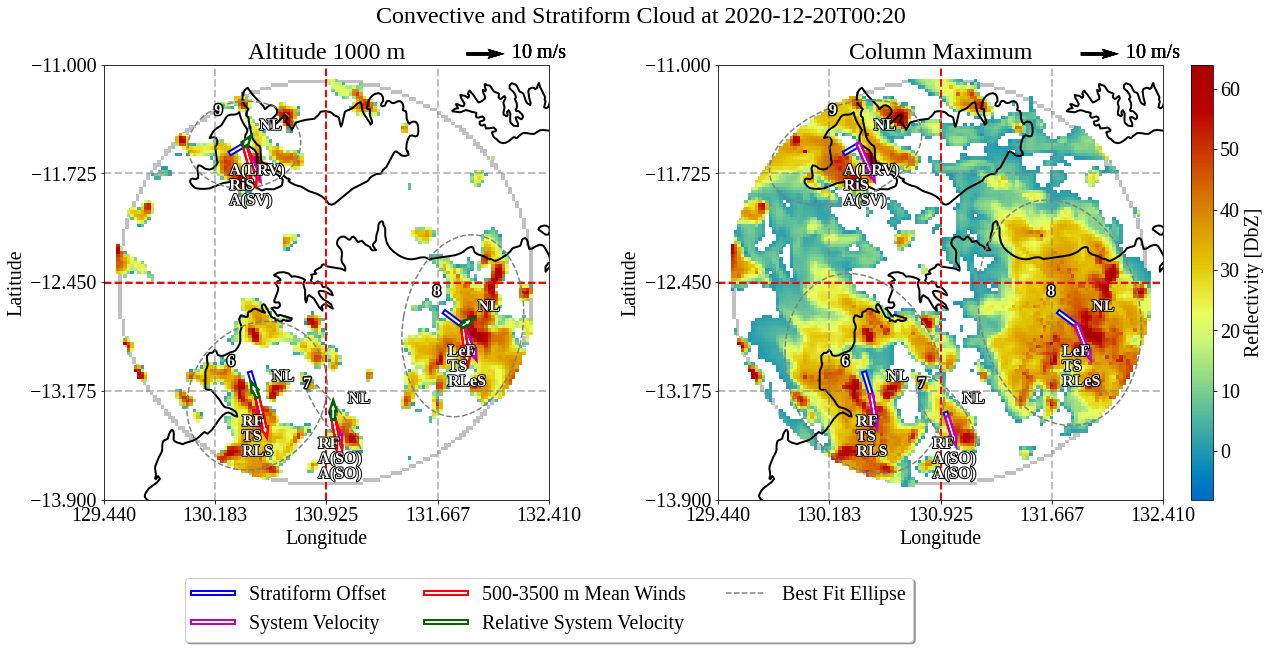

In [28]:
plot_datetime = np.datetime64('2020-12-20 00:20:00')

ACCESS_refl, grid = tint.process_ACCESS.init_ACCESS_C(plot_datetime, tracks_obj.reference_grid, gadi=False)

# filename = filenames[12]
# grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])

# ACCESS_refl = tint.process_ACCESS.

current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")

params = {
    'uid_ind': None, 'line_coords': False, 'center_cell': False,
    'cell_ind': 10, 'winds': False,
    'crosshair': True, 'fontsize': 20, 'colorbar_flag': True,
    'leg_loc': 2, 'label_type': 'velocities',
    'system_winds': ['shift', 'ambient_mean', 'relative'],
    'boundary': True, 'exclude': False}

tint.visualisation.figures.two_level(
    tracks_obj, grid, params=params, alt1=0, alt2=1)
plt.savefig(
    fig_dir + '/test_{}.png'.format(current_time), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

In [12]:
era5_all = xr.open_dataset(
    '/home/student.unimelb.edu.au/shorte1/Documents/era5_stuff/adaptor.mars.internal-1655789146.7190747-22014-23-f88f7808-4f1e-4fb9-b292-7e120594efb9.nc')

In [13]:
era5_all.time[-1]

<xarray.DataArray 'time' ()>
array('2022-05-30T23:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-05-30T23:00:00
Attributes:
    long_name:  time

In [18]:
era5_all.z.to_netcdf('/home/student.unimelb.edu.au/shorte1/Documents/era5_stuff/z_era5_oper_pl_20220401-20220430.nc')

In [11]:
era5_all.time

NameError: name 'era5_all' is not defined

> /tmp/ipykernel_25774/2239899693.py(1)<module>()
----> 1 era5_all.time

ipdb> q
